<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_c4i_square.png?raw=1" alt="Logo C4I" width=128px/>

<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_amds.png?raw=1" alt="Logo AMDS" width=128px/>

# AmsterdamUMCdb with Google BigQuery and Colaboratory
## AmsterdamUMCdb - Freely Accessible ICU Database

AmsterdamUMCdb version 1.5.0 May 2024  
Copyright &copy; 2003-2024 Amsterdam UMC - Amsterdam Medical Data Science

# Introduction
To encourage rapid data exploration and model development, access to AmsterdamUMCdb is also available using Google BigQuery with Google Colaboratory ('Colab') as the main coding environment. This removes the necessity of downloading the AmsterdamUMCdb csv files, setting up a database system and installing a coding environment.

Recently, AmsterdamUMCdb has been [converted](https://github.com/AmsterdamUMC/AMSTEL) to the [Observational Medical Outcomes Partnership Common Data Model version 5.4](https://ohdsi.github.io/CommonDataModel/cdm54.html) (OMOP CDM 5.4) maintained by the [Observational Health Data Sciences and Informatics](https://www.ohdsi.org/) (OHDSI) community. The transition from the original ('classic') AmsterdamUMCdb data format to the OMOP CDM should improve the reusability of both the data and analyses on the current and future version of database by closely adhering to the [FAIR](https://doi.org/10.1038/sdata.2016.18) (Findable, Accessible, Interoperable and Reusable) principles.

This tutorial for using AmsterdamUMCdb on BigQuery was based on the original Google BigQuery tutorial on [Colab](https://colab.research.google.com/notebooks/bigquery.ipynb).

# Running Colab
If not done already, please open Colab with this **getting_started** notebook from the official AmsterdamUMCdb GitHub repository: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/bigquery/getting_started.ipynb)

**Important**: when following this tutorial, make sure to follow *all* steps and to run the **code cells** using the **Play** button or by pressing `Ctrl-Enter`

# Before you Begin
Ensure you have a working Google account and verify that the e-mail address used when applying for access has been associated with this account. If you already have a Google account, you can add secondary e-mail addresses [here](https://myaccount.google.com/alternateemail), or alternatively create another Google account using the e-mail address used in the application form.

If you don't have any experience in using Jupyter notebooks and/or Python, it is recommended to familiarize yourself with the [basics](https://colab.research.google.com/notebooks/intro.ipynb).

# Accessing the database
Provided you have signed the end user license agreement, you will have free access to the data from AmsterdamUMCdb through the Google Cloud Platform.

To explore and query the database you need to create a Google Cloud Platform project. For new users, Google offers a free tier of 1 TB (2<sup>40</sup> bytes) per month for queries and in addition \$300 credit for free for use on the Google Cloud Platform (currently: \$6.00 per TB). In the unlikely event, this amount is not sufficient during a datathon or course, please contact us and we will work with you to find a solution.

# Signing up for Google Cloud Platform
- To sign up for the free tier and free credits, please visit the Google Cloud Platform: https://cloud.google.com/.
- Click **Get started for free**.
- Log in with the Google account you used when registering for the datathon.
- In Step 1 of 2: agree to the **Terms of Service** and select **Continue**.
- In Step 2 of 2: You will be required to add some additional information, including a payment method to make sure you are not a robot. Don't worry you won't be charged unless you manually upgrade to a paid account. Depending on your payment provider, you may have an additional step to verify the payment method.
- Finally press **Start my free trial**. You are good to go.



<a name="cell-project-id"></a>
# Retrieving your Google Cloud Project ID
- At the top of the screen, select **My First Project** or [create a new one](https://console.cloud.google.com/projectcreate). Please write down the Project ID in the cell below ("Insert text here") and **Run** the cell to store the value.

In [19]:
# sets *your* project id
PROJECT_ID = "project-b94b02e0-ce53-4cd7-9a8" #@param {type:"string"}

# Sets the default BigQuery dataset for accessing AmsterdamUMCdb

If you have received instructions to use a specific BigQuery instance, change the default settings here. Otherwise use these default values.

In [21]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'van_gogh_2026_datathon' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

# Provide your credentials to access the AmsterdamUMCdb dataset on Google BigQuery
Authenticate your credentials with Google Cloud Platform and set your default Google Cloud Project ID as an environment variable for running query jobs.

1. Run the cell. The `Allow this notebook to access your Google credentials?` prompt appears. Select `Allow`.
2. In the `Sign in - Google Accounts` dialog, use the account you registered during the AmsterdamUMCdb application process and select `Allow` again.

In [22]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


# Google BigQuery costs
Since BiqQuery uses a [columnar data structure](https://en.wikipedia.org/wiki/Column-oriented_DBMS), Google will charge you according to the columns selected and the size of the data in those columns. Especially in the data exploration phase, it is prudent to query only the columns you will be actually needing for the analysis.

To help reduce costs, the largest tables that contain device generated data, have been [partitioned](https://cloud.google.com/bigquery/docs/partitioned-tables) by `provider_id`. Unvalidated data (`provider_id IS NULL`) that has been filed up to every minute throughout the ICU stay has been stored in a separate partition. To protect against excessive costs, you are required to specifiy a `WHERE provider_id` clause when accessing these tables.

In addition, the tables have also been [clustered](https://cloud.google.com/bigquery/docs/clustered-tables) on `<domain>_concept_id`, `person_id`, and `<domain>_datetime`. By filtering using WHERE on these columns (in the above order), you can reduce the processing costs as well.

Some examples:

`SELECT * FROM measurements WHERE NOT provider_id IS NULL` will process about 11 GiB data, whereas

`SELECT person_id, visit_occurrence_id, measurement_concept_id, measurement_datetime, value_as_number, unit_concept_id FROM measurement WHERE NOT provider_id IS NULL` will process around 5.5 GiB.

**Important**: `LIMIT` or `WHERE` clauses on columns that have not been used in partitioning or clustering of the data do not have **any** effect on reducing the amount of data processed, and thus charged. These clauses will only limit the number of records returned by the query.

# Available documentation for AmsterdamUMCdb tables.
Since the migration to the OMOP Common Data Model, the official documentation for all tables can be found [here](https://ohdsi.github.io/CommonDataModel/cdm54.html).

# Enable data table display

Colab includes the `google.colab.data_table` package that can be used to display Pandas dataframes as an interactive data table (default limits: `max_rows = 20000`, `max_columns = 20`). This is especially useful when exploring the  tables or dictionary from AmsterdamUMCdb. It can be enabled with:

In [23]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


# Running your first query on AmsterdamUMCdb
BigQuery provides different ways to query the dataset:
- **magics**: the `bigquery_magics` library includes a `%%bigquery` *magic* command which runs a query and either displays the result or saves it to a Pandas DataFrame. The main advantage of this technique is that it improves readability of SQL code by syntax highlighting. Its main limitation: it requires a separate cell for the query, so cannot be combined with other Python code in the same code cell.

Let's query the `person` table using magics.



## Set the default query job configuration for magics

In [24]:
%load_ext bigquery_magics
from bigquery_magics import bigquery_magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
bigquery_magics.context.default_query_job_config = def_config

The bigquery_magics extension is already loaded. To reload it, use:
  %reload_ext bigquery_magics


## Query the `person` table and copy the data to the `persons` Pandas dataframe:

The `person` table contains a record for each patient in AmsterdamUMCdb.

Since this is a relatively small table, it is acceptable to use `SELECT *`.

**Note**: Should an error occur while running the query, please see
the AmsterdamUMCdb BigQuery [Frequently Asked Questions](https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/bigquery#faq).

In [25]:
%%bigquery person
SELECT * FROM person

Query is running:   0%|          |

Downloading:   0%|          |

In [27]:
%%bigquery cardiac_proxies
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(DISTINCT m.person_id) as unique_patients,
    ROUND(AVG(m.value_as_number), 1) as avg_value
FROM
    `measurement` m
JOIN
    `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    -- Search for CVP, Cardiac Output, or BNP (Lab test for heart failure)
    REGEXP_CONTAINS(LOWER(c.concept_name), r'central venous pressure|cvp|cardiac output|ci |cardiac index|bnp|pro-bnp')
GROUP BY
    1, 2
ORDER BY
    unique_patients DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [28]:
cardiac_proxies

,concept_id,concept_name,unique_patients,avg_value
0,21490675,Central venous pressure (CVP),28596,10.1
1,3000333,Central venous pressure (CVP) Mean,15401,15.2
2,3005555,Left ventricular Cardiac output,8923,5.3
3,21490712,Left ventricular Cardiac index,2580,2.8
4,21492228,Left ventricular Cardiac output by Continuous,2195,5.5
5,3002309,Left ventricular Cardiac output by Indicator d...,130,6.2


In [29]:
%%bigquery scores_df
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(DISTINCT m.person_id) as unique_patients
FROM
    `measurement` m
JOIN
    `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    -- Search for common ICU scores
    REGEXP_CONTAINS(LOWER(c.concept_name), r'glasgow|gcs|rass|sedation|pain|vas|cpot|delirium|cam-icu')
GROUP BY
    1, 2
ORDER BY
    unique_patients DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
scores_df

,concept_id,concept_name,unique_patients
0,21490853,Invasive Systolic blood pressure,47720
1,21490852,Invasive Mean blood pressure,43458
2,21490851,Invasive Diastolic blood pressure,36773
3,21492241,Mean blood pressure by Noninvasive,32776
4,3037253,Fluid intake intravascular Measured,24957
5,2000000013,Pain score (unspecified),23677
6,3016335,Glasgow coma score eye opening,21367
7,3008223,Glasgow coma score motor,21339
8,3009094,Glasgow coma score verbal,21333
9,3007194,Glasgow coma score total,21318


In [31]:
%%bigquery sepsis_proxy
SELECT
    c.concept_name,
    COUNT(DISTINCT d.person_id) as unique_patients
FROM
    `drug_exposure` d
JOIN
    `concept` c ON d.drug_concept_id = c.concept_id
WHERE
    -- Search for common IV antibiotics
    REGEXP_CONTAINS(LOWER(c.concept_name), r'ceftriaxone|meropenem|piperacillin|vancomycin|ciprofloxacin|metronidazole')
GROUP BY
    1
ORDER BY
    unique_patients DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
sepsis_proxy

,concept_name,unique_patients
0,ceftriaxone,11624
1,vancomycin,5601
2,ciprofloxacin,4853
3,metronidazole,4765
4,meropenem,1957
5,piperacillin,330
6,piperacillin / tazobactam,36


In [36]:
%%bigquery sepsis_by_proxy
WITH infection_evidence AS (
    -- Find patients who received a major IV antibiotic in the first 24h
    SELECT DISTINCT v.visit_occurrence_id
    FROM `visit_occurrence` v
    JOIN `drug_exposure` d ON v.person_id = d.person_id
    WHERE
        d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)
        -- Common broad-spectrum IV antibiotics
        AND d.drug_concept_id IN (1734104, 1713332, 1742425, 1310101, 1777042) -- (Ceftriaxone, Meropenem, Pip/Tazo, Vanco, Cipro)
),

organ_dysfunction AS (
    -- Find patients with high lactate OR on vasopressors in the first 24h
    SELECT DISTINCT v.visit_occurrence_id
    FROM `visit_occurrence` v
    LEFT JOIN `measurement` m ON v.person_id = m.person_id
    LEFT JOIN `drug_exposure` d ON v.person_id = d.person_id
    WHERE
        -- High Lactate (ID 3007293)
        (m.measurement_concept_id = 3007293 AND m.value_as_number > 2.0 AND m.measurement_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR))
        OR
        -- On Norepinephrine (ID 1321341)
        (d.drug_concept_id = 1321341 AND d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR))
)

SELECT
    i.visit_occurrence_id
FROM infection_evidence i
JOIN organ_dysfunction o ON i.visit_occurrence_id = o.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [37]:
sepsis_by_proxy

,visit_occurrence_id
0,33330
1,86
2,2105
3,10729
4,961
...,...
586,77840
587,17669
588,61318
589,40582


In [38]:
# 1. Count the patients found
sepsis_proxy_count = len(sepsis_by_proxy['visit_occurrence_id'].unique())
print(f"Found {sepsis_proxy_count} patients meeting the Sepsis-3 clinical definition.")

# 2. Run the mortality comparison using this new cohort
# (This re-uses the sepsis_outcomes query, but points it to our new proxy table)

# First, we need to make the list of IDs available to the next SQL cell
# This is a special command for BigQuery Magics
%gcs store sepsis_by_proxy --destination_format parquet

# Now run the comparison

Found 591 patients meeting the Sepsis-3 clinical definition.


UsageError: Line magic function `%gcs` not found.


In [41]:
%%bigquery sepsis_outcomes
-- =================================================================
-- Part 1: Define the Sepsis Cohort using the Clinical Proxy (Sepsis-3)
-- This entire block becomes our temporary table, called "sepsis_admissions"
-- =================================================================
WITH sepsis_admissions AS (
    WITH infection_evidence AS (
        -- Find patients who received a major IV antibiotic in the first 24h
        SELECT DISTINCT v.visit_occurrence_id
        FROM `visit_occurrence` v
        JOIN `drug_exposure` d ON v.person_id = d.person_id
        WHERE
            d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)
            AND d.drug_concept_id IN (1734104, 1713332, 1742425, 1310101, 1777042) -- (Ceftriaxone, Meropenem, Pip/Tazo, Vanco, Cipro)
    ),

    organ_dysfunction AS (
        -- Find patients with high lactate OR on vasopressors in the first 24h
        SELECT DISTINCT v.visit_occurrence_id
        FROM `visit_occurrence` v
        LEFT JOIN `measurement` m ON v.person_id = m.person_id
        LEFT JOIN `drug_exposure` d ON v.person_id = d.person_id
        WHERE
            (m.measurement_concept_id = 3007293 AND m.value_as_number > 2.0 AND m.measurement_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR))
            OR
            (d.drug_concept_id = 1321341 AND d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR))
    )

    SELECT
        i.visit_occurrence_id
    FROM infection_evidence i
    JOIN organ_dysfunction o ON i.visit_occurrence_id = o.visit_occurrence_id
)

-- =================================================================
-- Part 2: Calculate the Outcomes using the Sepsis Cohort we just defined
-- =================================================================
SELECT
    CASE
        WHEN v.visit_occurrence_id IN (SELECT visit_occurrence_id FROM sepsis_admissions) THEN 'Sepsis (Clinical Proxy)'
        ELSE 'Non-Sepsis'
    END as cohort,

    COUNT(DISTINCT v.visit_occurrence_id) as total_admissions,

    -- Mortality Rate
    ROUND(AVG(CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END) * 100, 2) as mortality_rate_pct

FROM `visit_occurrence` v
LEFT JOIN `person` p ON v.person_id = p.person_id
LEFT JOIN `death` d ON p.person_id = d.person_id
GROUP BY 1

Query is running:   0%|          |

Downloading:   0%|          |

--- Mortality Comparison ---
                    cohort  total_admissions  mortality_rate_pct
0               Non-Sepsis             79247               21.24
1  Sepsis (Clinical Proxy)               591               40.94


/tmp/ipython-input-411689489.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


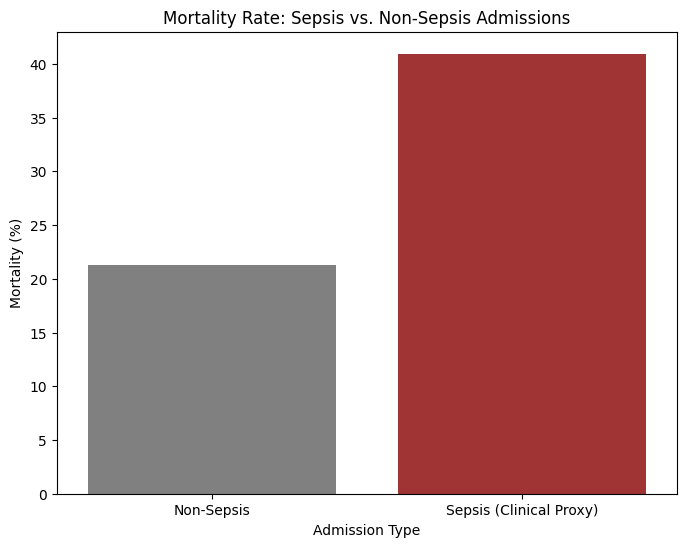

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Mortality Comparison ---")
print(sepsis_outcomes)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=sepsis_outcomes,
    x='cohort',
    y='mortality_rate_pct',
    palette={'Sepsis (Clinical Proxy)': 'firebrick', 'Non-Sepsis': 'gray'}
)
plt.title("Mortality Rate: Sepsis vs. Non-Sepsis Admissions")
plt.ylabel("Mortality (%)")
plt.xlabel("Admission Type")
plt.show()

In [43]:
%%bigquery sofa_concepts
SELECT
    c.concept_name,
    c.concept_id,
    COUNT(DISTINCT m.person_id) as patient_count
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    REGEXP_CONTAINS(LOWER(c.concept_name), r'pao2|fio2|platelet|bilirubin|creatinine|glasgow|gcs|urine output')
GROUP BY 1, 2
ORDER BY patient_count DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [44]:
sofa_concepts

,concept_name,concept_id,patient_count
0,Creatinine [Moles/volume] in Serum or Plasma,3020564,49923
1,Platelets [#/volume] in Blood,3007461,47350
2,aPTT in Platelet poor plasma by Coagulation assay,3018677,42933
3,fio2 setting,2000000204,37457
4,INR in Platelet poor plasma by Coagulation assay,3022217,27484
5,Urine output,3014315,24933
6,Glasgow coma score eye opening,3016335,21367
7,Glasgow coma score motor,3008223,21339
8,Glasgow coma score verbal,3009094,21333
9,Glasgow coma score total,3007194,21318


In [45]:
%%bigquery pao2_id
SELECT
    c.concept_name,
    c.concept_id,
    COUNT(DISTINCT m.person_id) as patient_count
FROM `measurement` m
JOIN `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    LOWER(c.concept_name) LIKE '%oxygen [partial pressure] in arterial blood%'
GROUP BY 1, 2
ORDER BY patient_count DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [46]:
pao2_id

,concept_name,concept_id,patient_count
0,Oxygen [Partial pressure] in Arterial blood,3027801,35379


In [48]:
%%bigquery sofa_scores
WITH first_day_vitals AS (
    -- 1. Extract the worst value for each component in the first 24 hours
    SELECT
        v.visit_occurrence_id,

        -- RESPIRATORY
        MAX(CASE WHEN m.measurement_concept_id = 2000000204 THEN m.value_as_number END) as fio2,
        MIN(CASE WHEN m.measurement_concept_id = 3027801 THEN m.value_as_number END) as pao2,

        -- COAGULATION
        MIN(CASE WHEN m.measurement_concept_id = 3007461 THEN m.value_as_number END) as platelets,

        -- LIVER
        MAX(CASE WHEN m.measurement_concept_id = 3043995 THEN m.value_as_number END) as bilirubin,

        -- CARDIOVASCULAR
        MIN(CASE WHEN m.measurement_concept_id = 21490852 THEN m.value_as_number END) as map,

        -- CNS
        MIN(CASE WHEN m.measurement_concept_id = 3007194 THEN m.value_as_number END) as gcs,

        -- RENAL
        MAX(CASE WHEN m.measurement_concept_id = 3020564 THEN m.value_as_number END) as creatinine,
        SUM(CASE WHEN m.measurement_concept_id = 3014315 THEN m.value_as_number END) as urine_output_24h

    FROM `visit_occurrence` v
    JOIN `measurement` m ON v.person_id = m.person_id
    WHERE
        m.measurement_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY v.visit_occurrence_id
),

first_day_vaso AS (
    -- 2. Check for vasopressor use in the first 24 hours
    SELECT
        v.visit_occurrence_id,
        MAX(CASE WHEN d.drug_concept_id IN (1321341, 1337860, 1343916) THEN 1 ELSE 0 END) as on_vasopressor
    FROM `visit_occurrence` v
    JOIN `drug_exposure` d ON v.person_id = d.person_id
    WHERE
        d.drug_exposure_start_datetime BETWEEN v.visit_start_datetime AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 24 HOUR)
    GROUP BY v.visit_occurrence_id
),

sofa_points AS (
    -- 3. Calculate points for each organ system, with correct unit conversions
    SELECT
        v.visit_occurrence_id,

        CASE
            WHEN SAFE_DIVIDE(v.pao2, v.fio2 / 100) < 100 THEN 4
            WHEN SAFE_DIVIDE(v.pao2, v.fio2 / 100) < 200 THEN 3
            WHEN SAFE_DIVIDE(v.pao2, v.fio2 / 100) < 300 THEN 2
            WHEN SAFE_DIVIDE(v.pao2, v.fio2 / 100) < 400 THEN 1
            ELSE 0
        END as respiration_sofa,

        CASE
            WHEN v.platelets < 20 THEN 4
            WHEN v.platelets < 50 THEN 3
            WHEN v.platelets < 100 THEN 2
            WHEN v.platelets < 150 THEN 1
            ELSE 0
        END as coagulation_sofa,

        CASE
            WHEN v.bilirubin > 204 THEN 4
            WHEN v.bilirubin > 102 THEN 3
            WHEN v.bilirubin > 33 THEN 2
            WHEN v.bilirubin > 19 THEN 1
            ELSE 0
        END as liver_sofa,

        CASE
            WHEN d.on_vasopressor = 1 THEN 4
            WHEN v.map < 70 THEN 1
            ELSE 0
        END as cardiovascular_sofa,

        CASE
            WHEN v.gcs < 6 THEN 4
            WHEN v.gcs < 10 THEN 3
            WHEN v.gcs < 13 THEN 2
            WHEN v.gcs < 15 THEN 1
            ELSE 0
        END as cns_sofa,

        CASE
            WHEN v.creatinine > 440 OR v.urine_output_24h < 200 THEN 4
            WHEN v.creatinine > 300 OR v.urine_output_24h < 500 THEN 3
            WHEN v.creatinine > 171 THEN 2
            WHEN v.creatinine > 110 THEN 1
            ELSE 0
        END as renal_sofa -- <<< FIX: ADDED A COMMA HERE

    FROM first_day_vitals v
    LEFT JOIN first_day_vaso d ON v.visit_occurrence_id = d.visit_occurrence_id
)

-- 4. Sum the points for the final score
SELECT
    s.visit_occurrence_id,
    (s.respiration_sofa + s.coagulation_sofa + s.liver_sofa + s.cardiovascular_sofa + s.cns_sofa + s.renal_sofa) as sofa_score
FROM sofa_points s

Query is running:   0%|          |

Downloading:   0%|          |

In [55]:
%%bigquery demographics_df
SELECT
    p.person_id,
    v.visit_occurrence_id,

    -- Gender
    c.concept_name as gender,

    -- Age (Approximate based on year)
    (EXTRACT(YEAR FROM v.visit_start_date) - p.year_of_birth) as age,

    -- Length of Stay (Days)
    TIMESTAMP_DIFF(v.visit_end_datetime, v.visit_start_datetime, HOUR) / 24.0 as los_days,

    -- Outcome
    CASE WHEN d.death_date IS NOT NULL THEN 'Expired' ELSE 'Survived' END as outcome

FROM `visit_occurrence` v
JOIN `person` p ON v.person_id = p.person_id
LEFT JOIN `concept` c ON p.gender_concept_id = c.concept_id
LEFT JOIN `death` d ON p.person_id = d.person_id
WHERE
    -- Filter reasonable ages and stays > 24h
    (EXTRACT(YEAR FROM v.visit_start_date) - p.year_of_birth) BETWEEN 18 AND 100
    AND TIMESTAMP_DIFF(v.visit_end_datetime, v.visit_start_datetime, HOUR) > 24

Query is running:   0%|          |

Downloading:   0%|          |

/tmp/ipython-input-702290553.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


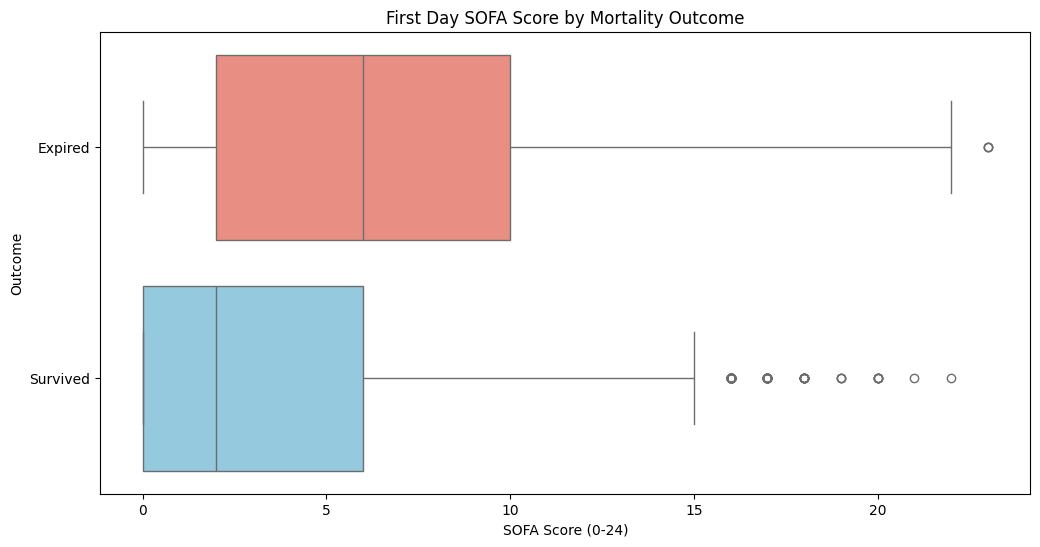

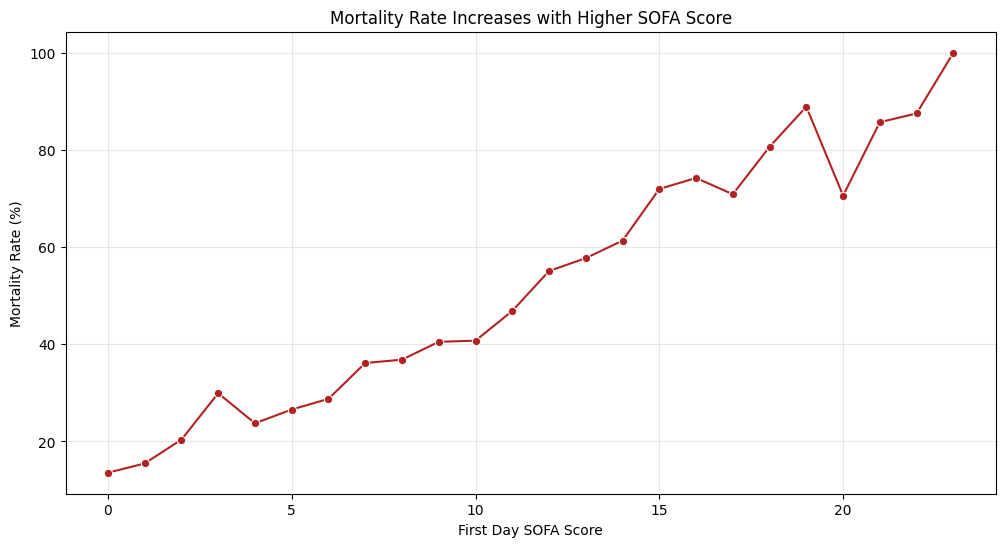

In [56]:
# --- FIX: Add the necessary imports at the top ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Merge SOFA scores with outcomes
# (Assuming you have the 'demographics_df' from previous steps)
sofa_with_outcomes = pd.merge(
    sofa_scores,
    demographics_df[['visit_occurrence_id', 'outcome']],
    on='visit_occurrence_id',
    how='inner'
)

# 2. Visualize the distribution
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=sofa_with_outcomes,
    x='sofa_score',
    y='outcome',
    orient='h',
    palette={'Survived': 'skyblue', 'Expired': 'salmon'}
)
plt.title("First Day SOFA Score by Mortality Outcome")
plt.xlabel("SOFA Score (0-24)")
plt.ylabel("Outcome")
plt.show()

# 3. Calculate Mortality Rate per SOFA score
mortality_by_sofa = sofa_with_outcomes.groupby('sofa_score')['outcome'].apply(lambda x: (x == 'Expired').mean() * 100).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=mortality_by_sofa, x='sofa_score', y='outcome', marker='o', color='firebrick')
plt.title("Mortality Rate Increases with Higher SOFA Score")
plt.xlabel("First Day SOFA Score")
plt.ylabel("Mortality Rate (%)")
plt.grid(True, alpha=0.3)
plt.show()

In [57]:
%%bigquery pneumonia_by_code
WITH pneumonia_concepts AS (
    -- 1. Find all diagnosis codes that are descendants of "Pneumonia"
    SELECT descendant_concept_id
    FROM `concept_ancestor`
    WHERE ancestor_concept_id = 255848 -- This is the OMOP parent concept for Pneumonia
)

SELECT
    v.visit_occurrence_id,
    v.person_id,
    c.concept_name as pneumonia_diagnosis,
    co.condition_start_datetime
FROM `visit_occurrence` v
JOIN `condition_occurrence` co ON v.person_id = co.person_id
JOIN `concept` c ON co.condition_concept_id = c.concept_id
WHERE
    -- Only look for conditions recorded during the visit
    co.condition_start_datetime BETWEEN v.visit_start_datetime AND v.visit_end_datetime
    -- Filter for conditions recorded in the first 24 hours (Admission Diagnosis)
    AND TIMESTAMP_DIFF(co.condition_start_datetime, v.visit_start_datetime, HOUR) <= 24
    -- Check if the diagnosis is one of the pneumonia codes
    AND co.condition_concept_id IN (SELECT descendant_concept_id FROM pneumonia_concepts)

Query is running:   0%|          |

Downloading: |          |

In [58]:
pneumonia_by_code

,visit_occurrence_id,person_id,pneumonia_diagnosis,condition_start_datetime


## Display the `person` dataframe.

In [39]:
%%bigquery sepsis_outcomes
-- Load the list of Sepsis IDs we just found
WITH sepsis_admissions AS (
    SELECT visit_occurrence_id FROM bqutil.gcs.read_parquet('gs://bqutil-temp-storage-us/sepsis_by_proxy/*')
)

SELECT
    CASE
        WHEN v.visit_occurrence_id IN (SELECT visit_occurrence_id FROM sepsis_admissions) THEN 'Sepsis (Clinical Proxy)'
        ELSE 'Non-Sepsis'
    END as cohort,

    COUNT(DISTINCT v.visit_occurrence_id) as total_admissions,

    -- Mortality Rate
    ROUND(AVG(CASE WHEN d.death_date IS NOT NULL THEN 1 ELSE 0 END) * 100, 2) as mortality_rate_pct

FROM `visit_occurrence` v
LEFT JOIN `person` p ON v.person_id = p.person_id
LEFT JOIN `death` d ON p.person_id = d.person_id
GROUP BY 1

Executing query with job ID: 55998ea2-a39b-4c36-86cd-9c95bae1d481
Query executing: 0.59s


ERROR:
 400 Table-valued function not found: bqutil.gcs.read_parquet at [3:37]; reason: invalidQuery, location: query, message: Table-valued function not found: bqutil.gcs.read_parquet at [3:37]

Location: EU
Job ID: 55998ea2-a39b-4c36-86cd-9c95bae1d481



In [ ]:
person

# Query AmsterdamUMCdb through google-cloud-bigquery

Alternatively, we can manually invoke the `biqquery` Python module. The following examples re-use the previously entered `PROJECT_ID` from [Retrieving your Google Cloud Project ID](#cell-project-id). For more information, see [BigQuery documentation](https://cloud.google.com/bigquery/docs) and [library reference documentation](https://googleapis.dev/python/bigquery/latest/index.html).


## Set the default query job configuration for google-cloud-bigquery client

In [ ]:
from google.cloud import bigquery

# BigQuery requires a separate config to prevent the 'BadRequest: 400 Cannot explicitly modify anonymous table' error message
job_config = bigquery.job.QueryJobConfig()

# sets default client settings by re-using the previously defined config
client = bigquery.Client(project=PROJECT_ID, location=LOCATION, default_query_job_config=def_config)

## Get all patients and group by year of birth

In [ ]:
year_of_birth = client.query(
    '''
    SELECT
      year_of_birth
      , COUNT(*) AS number_of_admissions -- COUNT(*) counts everything including NULL
    FROM person
    GROUP BY year_of_birth
    ORDER BY year_of_birth ASC
    '''
    , job_config=job_config).to_dataframe()

year_of_birth

## Show a plot
Uses the Pandas built-in functions to plot a bar chart.

In [ ]:
# modifies the pyplot back-end of Pandas to increase render resolution
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams["figure.dpi"] = 144

year_of_birth.plot(kind='bar', x='year_of_birth')

# Visit_occurrence
This table stores information about the ICU admissions. Patients (`person`) can have multiple visit_occurrence records.

This table is very similar to the legacy `admissions` table.

In [ ]:
visit_occurrence = client.query(
    '''
    SELECT *
    FROM visit_occurrence
    '''
    , job_config=job_config).to_dataframe()

visit_occurrence

In [ ]:
provider = client.query(
    '''
    SELECT *
    FROM provider
    '''
    , job_config=job_config).to_dataframe()

provider

## Concept

In [ ]:
concept = client.query(
    '''
    SELECT *
    FROM concept
    WHERE concept_id = 38004497
    '''
    , job_config=job_config).to_dataframe()

concept

# Query AmsterdamUMCdb through pandas-gbq

The third option is to query the dataset using the Pandas `pandas-gbq` library. Especially when you are already familiar with the `pandas.read_sql` function, it's relatively straightforward to modify your existing code to be compatible with BigQuery. For more information, see [Pandas GBQ Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_gbq.html).


**Note**: The `use_bqstorage_api=True` statement enables the Google Cloud BigQuery Storage API that improves the performance of copying data from BiqQuery to pandas DataFrames in the Colab environment (~around 16 times). While the usage of the Storage Read API is being charged separately, Google currently offers a free tier of 300 TB per month. However, you may choose to remove the option from the command.

## Set the default query job configuration for pandas-gbq

In [ ]:
import pandas as pd

config_gbq = {'query':
          {'defaultDataset': {
              "datasetId": DATASET_ID,
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

## Retrieve the medical specialty associated with each admission

In [ ]:
specialties = pd.read_gbq(
    '''
    SELECT concept_name AS specialty, COUNT(*) AS number_of_admissions
    FROM visit_occurrence v
    LEFT JOIN provider p ON p.provider_id = v.provider_id
    LEFT JOIN concept c ON c.concept_id = p.specialty_concept_id

    GROUP BY specialty
    ORDER BY number_of_admissions DESC
    '''
    , configuration=config_gbq, use_bqstorage_api=True)
specialties.plot(kind='bar', x='specialty')

# Getting the data you need
The `amsterdamumcdb` package provides the `get_dictionary()` function that returns a DataFrame containing all codes and (categorical) values ('concepts') of AmsterdamUMCdb. As part of the transformation to the OMOP Common Data Model, most concepts have been mapped to a Standard Concept in the [OMOP Standardized Vocabularies](https://ohdsi.github.io/TheBookOfOhdsi/StandardizedVocabularies.html).

The Standardized Vocabularies are a common respository for commonly used vocabularies such as [LOINC](https://decor.nictiz.nl/art-decor/loinc), [SNOMED CT](https://decor.nictiz.nl/art-decor/snomed-ct), [RxNorm](https://mor.nlm.nih.gov/RxNav/) and [ATC](https://www.whocc.no/atc_ddd_index/). The OMOP Standardized Vocabularies are available at [ATHENA](https://athena.ohdsi.org/search-terms/start).

**Note for users of the legacy (non-OMOP) versions (≤ 1.0.2) of AmsterdamUMCdb**

The original `itemid` is stored as `source_code` and `item` as `source_code_description` in the dictionary. To allow mapping of categorical values from the legacy `listitems` table to standard concepts, the `source_code` was generated using the format `{itemid}-{valueid}`. In addition, the `source_code` from the legacy `drugitems` was generated using the `{itemid}-{ordercategoryid}` format.

## Install the AmsterdamUMCdb package

In [ ]:
# get the amsterdamumcdb package from PyPI repository for use in Colab
!pip install amsterdamumcdb
import amsterdamumcdb as adb

## Load the AmsterdamUMCdb dictionary.
Use the **Filter** button to quickly browse through the dictionary.

In [ ]:
dictionary = adb.get_dictionary()
dictionary = dictionary.convert_dtypes()
dictionary

# Selecting relevant features


## Example: Lactate
Lactate, a laboratory measurement, can be found in the `measurement` table.

Since this is the largest table of AmsterdamUMCdb (188 GiB), it is highly recommended to correctly filter the query on:
- `provider_id` and
  - `measurement_concept_id` or
  - `measurement_concept_id`/`person_id` or
  - `measurement_concept_id`/`person_id`/`measurement_start_time`

### Get all lactate itemids

In [ ]:
lactate_ids = dictionary[dictionary['concept_name'].str.contains(r'lactate', case=False)]
lactate_ids

## Get lactate values for all patients

In [ ]:
lactate = pd.read_gbq(
    '''
    SELECT
      person_id,
      visit_occurrence_id,
      measurement_concept_id,
      measurement_datetime,
      measurement_type_concept_id,
      value_as_number,
      unit_concept_id,
      provider_id
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
      3047181,  -- Lactate [Moles/volume] in Blood
      3014111,  -- Lactate [Moles/volume] in Serum
      3047181   -- Lactate [Moles/volume] in Blood
    )
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

#show number of records in the dataframe
print(f'Number of lactate values: {len(lactate)}')

#show first 1000 items
lactate.convert_dtypes().head(1000)

### Plot lactate values using default pandas histogram function

In [ ]:
lactate['value'] = lactate['value_as_number'].astype('float')
lactate['value'].hist()

### Plot lactate values using outlier aware histogram from AmsterdamUMCdb library

In [ ]:
adb.outliers_histogram(data=lactate['value']).show()

In [ ]:
adb.outliers_histogram(data=lactate['value'], z_threshold=16).show()

In [ ]:
lactate[lactate['value'] > 15].sort_values('value', ascending=False)

This table demonstrates that the top 6 highest values are most likely data entry errors. They were also manually documented in the EHR (`measurement_type_concept_id` = [32817](https://athena.ohdsi.org/search-terms/terms?standardConcept=Standard&invalidReason=Valid&domain=Type+Concept&page=1&pageSize=15&query=32817)), instead of being filed by the Laboratory system (`measurement_type_concept_id` = [32856](https://athena.ohdsi.org/search-terms/terms?standardConcept=Standard&invalidReason=Valid&domain=Type+Concept&page=1&pageSize=15&query=32856&boosts)).

## Example: Acute kidney injury: creatinine
Creatinine, a laboratory measurement that reflects kidney function, can also be found in the `measurement` table.

### Get all creatinine itemids

In [ ]:
creatinine_ids = dictionary[dictionary['concept_name'].str.contains(r'creatinine', case=False)]
creatinine_ids

### Get creatinine values for all patients

In [ ]:
creatinine = pd.read_gbq(
    '''
    SELECT
      person_id,
      visit_occurrence_id,
      measurement_concept_id,
      measurement_datetime,
      measurement_type_concept_id,
      value_as_number,
      unit_concept_id,
      provider_id
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
        3020564 -- Creatinine [Moles/volume] in Serum or Plasma
    )
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

#show number of records in the dataframe
print(f'Number of creatinine values: {len(creatinine)}')

#show first 1000 items
creatinine.head(1000)

### Plot creatinine values using default pandas histogram function

In [ ]:
creatinine['value'] = creatinine['value_as_number'].astype('float')
creatinine['value'].hist()

### Plot creatinine values using outlier aware histogram from AmsterdamUMCdb library

In [ ]:
adb.outliers_histogram(data=creatinine['value']).show()

In [ ]:
adb.outliers_histogram(data=creatinine['value'], z_threshold=16).show()

In [ ]:
creatinine[creatinine['value'] > 500].sort_values('value', ascending=False)

In [ ]:
creat_patient = pd.read_gbq(
    '''
    SELECT
      person_id,
      visit_occurrence_id,
      measurement_concept_id,
      measurement_datetime,
      measurement_type_concept_id,
      CAST(value_as_number AS FLOAT64) as value_as_number,
      unit_concept_id,
      provider_id
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
        3020564 -- Creatinine [Moles/volume] in Serum or Plasma
      )
      AND visit_occurrence_id = 1583
    ORDER BY measurement_datetime
    '''
    , configuration=config_gbq, use_bqstorage_api=True)
creat_patient

This table demonstrates that the highest value is most likely a data entry error: it was manually documented, instead of filed by the system (Dutch: 'Systeem')

# Tips and Tricks

# Getting related items
Assume you have determined that concept_id `40729817` (Hydrocortisone 100 MG Injectable Solution [Solu-Cortef]) is of interest, but would like to know if other steroids have been used on our unit.

In [ ]:
ancestors = pd.read_gbq(
    '''
    SELECT ancestor_concept_id, descendant_concept_id, min_levels_of_separation, concept_name, vocabulary_id, concept_class_id
    FROM concept_ancestor
    LEFT JOIN concept
      ON concept_ancestor.ancestor_concept_id = concept.concept_id
    WHERE descendant_concept_id = 40729817 -- Hydrocortisone 100 MG Injectable Solution [Solu-Cortef]
    ORDER BY min_levels_of_separation DESC
    '''
    , configuration=config_gbq, use_bqstorage_api=True)
ancestors

In [ ]:
descendants = pd.read_gbq(
    '''
    SELECT descendant_concept_id
    FROM concept_ancestor
    WHERE ancestor_concept_id = 21602728 -- Glucocorticoids
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

# filter dictionary on all descendants
dictionary[dictionary['concept_id'].isin(descendants['descendant_concept_id'])]

In [ ]:
corticosteroids = pd.read_gbq(
    '''
    SELECT *
    FROM drug_exposure
    WHERE drug_concept_id IN (
      40028601,	-- dexamethasone Oral Tablet
      40028260,  -- dexamethasone Injectable Solution
      40049700,	-- hydrocortisone Oral Tablet
      40729817,  -- Hydrocortisone 100 MG Injectable Solution [Solu-Cortef]
      40073458,	-- prednisolone Oral Tablet
      40073191,	-- prednisolone Injectable Solution
      40060704,  -- methylprednisolone Injectable Solution [Solu-Medrol]
      40060704	-- methylprednisolone Injectable Solution [Solu-Medrol]
    )
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

## Conclusion
This finalizes our tutorial on accessing AmsterdamUMCdb using BigQuery.

### What's next?
- Have a look at the AmsterdamUMCdb [wiki](https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki).
- More examples are available for the legacy tables. You can use the dictionary to translate the legacy `source_code`s to `concept_id`s. Future work will update this repository with examples for the OMOP Common Data Model.

Table | Wiki | Example code
:- | :--| -:
admissions|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/admissions | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/admissions.ipynb)
drugitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/drugitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/drugitems.ipynb)
freetextitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/freetextitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/freetextitems.ipynb)
listitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/lisitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/listitems.ipynb)
numericitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/numericitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/numericitems.ipynb)
procedureorderitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/procedureorderitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/procedureorderitems.ipynb)
processitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/processitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/processitems.ipynb)

- Examine the [concepts](https://github.com/AmsterdamUMC/AmsterdamUMCdb/tree/master/concepts) for definitions related to diagnoses, life support systems, including mechanical ventilation and renal replacement therapy, and ICU scoring systems.
- And remember: medical data science is always a joint effort of disciplines, so start a discussion with your colleagues or team members early on how to approach your clinical problem.
